In [85]:
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
import torch
import os
from pathlib import Path
import glob
import torch.nn as nn
from itertools import chain
import torch.optim as optim
import time
from progressbar import ETA, Bar, Percentage, ProgressBar
import simpleaudio as sa
# from model_Adp import *
from model_Adp_custom import *
import scipy.io as sio
from torchvision.io import read_image
import torchvision.transforms as transforms
from torchvision.transforms.functional import pad
from torch.utils.data import Dataset
import torchvision.utils as vutils
from torchvision.transforms import *
import torchvision
from collections import defaultdict
from IPython.display import display, clear_output
import torchaudio
from torchvision.transforms.functional import pad
from matplotlib.lines import Line2D

import joblib

import librosa
from tqdm import tqdm

from utils import audio_tools as audio
from utils.hparams import *

In [2]:
SR = hparams['sample_rate']
IMAGE_SIZE = 128 # Generate melspectrogram image in 128 x 128

In [3]:
# cuda = torch.cuda.is_available()
# print(cuda)

ngpu = 2
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

cuda:0


In [4]:
# # Read MNIST meta file and move folders to respective male and female folders
# import json
# import shutil
  
# # reading the data from the file
# with open('data/AudioMNIST/audioMNIST_meta.txt') as f:
#     data = f.read()
    
# data = json.loads(data)

# for key, value in data.items():
#     if value['gender'] == "male":
#         for file in glob.glob("./data/AudioMNIST/"+key+"/*"):
#             shutil.move(file, "./data/AudioMNIST/male/"+Path(file).stem+".wav")
#     elif value['gender'] == "female":
#         for file in glob.glob("./data/AudioMNIST/"+key+"/*"):
#             shutil.move(file, "./data/AudioMNIST/female/"+Path(file).stem+".wav")

In [5]:
# path_test = "data/wavfiles16kHz/TEST"
# path_train = "data/wavfiles16kHz/TRAIN"

path_A = "data/AudioMNIST/male"
path_B = "data/AudioMNIST/female"

n = 5000

files_A = glob.glob(path_A+"/*.wav")[:n]
files_B = glob.glob(path_B+"/*.wav")[:n]

In [6]:
# PREPROCESS
# calculate means/standard diviation for normalization

def load_audio(path):
    y, sr = librosa.core.load(path, sr = SR)

    # sfft -> mel conversion
    db_mel = audio.melspectrogram(y)

    # means/standard diviation for each freq bin
    m_db_mel = np.mean(db_mel, axis=1)
    std_db_mel = np.std(db_mel, axis=1)
    return m_db_mel, std_db_mel
    
# parallel loading
results = joblib.Parallel(n_jobs=-1)(
    joblib.delayed(load_audio)(path) for path in files_A)

means = [mean for mean, _ in results if mean is not None]
stds = [std for _, std in results if std is not None]

# calcurate overall means/standard diviation
means = np.array(means)
stds = np.array(stds)

mel_means = np.mean(means, axis=0)
mel_stds = np.mean(stds, axis=0)

In [7]:
def as_np(data):
    return data.cpu().data.numpy()

In [8]:
# waveform, sample_rate = torchaudio.load(files_A[1])

# class AudioNormalize(object):
#     def __init__(self, x):
#         self.x = x

#     "Normalizes a single `AudioTensor`."
#     def encodes(self): return (self.x-self.x.mean()) / self.x.std()

# print(waveform.mean())
# print(waveform.var())

# def extract_logmel(y, sr, size=3):
#     """
#     extract log mel spectrogram feature
#     :param y: the input signal (audio time series)
#     :param sr: sample rate of 'y'
#     :param size: the length (seconds) of random crop from original audio, default as 3 seconds
#     :return: log-mel spectrogram feature
#     """
#     # normalization
#     y = y.astype(np.float32)
#     normalization_factor = 1 / np.max(np.abs(y))
#     y = y * normalization_factor

#     # extract log mel spectrogram
#     melspectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024, n_mels=128)
#     logmelspec = librosa.power_to_db(melspectrogram)

#     return logmelspec 

# ps_db = extract_logmel(as_np(waveform).squeeze(), sample_rate)

# print(ps_db.mean())
# print(ps_db.var())

# fig, ax = plt.subplots(figsize=(5,10))
# plt.imshow(ps_db, origin="lower", cmap=plt.get_cmap("magma"))

In [9]:
# def padding(array, xx, yy):
#     """
#     :param array: numpy array
#     :param xx: desired height
#     :param yy: desirex width
#     :return: padded array
#     """

#     h = array.shape[0]
#     w = array.shape[1]

#     a = (xx - h) // 2
#     aa = xx - a - h

#     b = (yy - w) // 2
#     bb = yy - b - w

#     return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')

In [10]:
# # sample_rate, samples = wavfile.read(test_files[3])
# # frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)

# # y, sr = librosa.load(files_A[1])
# ps = librosa.feature.melspectrogram(y=y, sr=sr)
# ps_db= librosa.power_to_db(ps, ref=np.max)

# # ps_db = padding(ps_db, 256, 256)

# # librosa.display.specshow(ps_db, x_axis='s', y_axis='log')
# fig, ax = plt.subplots(figsize=(5,10))
# plt.imshow(ps_db, origin="lower", cmap=plt.get_cmap("magma"))

In [11]:
# Image to npy array
spect_dir_A = "./data/spectrograms/A/" 
spect_dir_B = "./data/spectrograms/B/" 

In [12]:
# scaling - based on
# Donahue, C., McAuley, J., & Puckette, M. (2018). Synthesizing Audio with Generative Adversarial Networks.
# Retrieved from http://arxiv.org/abs/1802.04208
def normalize(s):
    assert s.shape[0] == mel_means.shape[0]
    norm_Y = (s - mel_means) / (3.0 * mel_stds)
    return np.clip(norm_Y, -1.0, 1.0)

def denormalize(norm_s):
    assert norm_s.shape[0] == mel_means.shape[0]
    Y = (norm_s * (3.0 * mel_stds)) + mel_means
    return Y

def load_melspecs(path):
    filename = os.path.basename(path)

    y, sr = librosa.core.load(path, sr = SR)

    db_mel = audio.melspectrogram(y)
    assert  db_mel.shape[0] == IMAGE_SIZE

    dummy = np.ones((IMAGE_SIZE, IMAGE_SIZE)) * hparams['min_level_db']
    db_mel = np.hstack((db_mel, dummy))
    db_mel = db_mel[:, :IMAGE_SIZE]

    norm_mel = normalize(db_mel)

    return norm_mel

In [13]:
def save_as_np(files, savepath):
    print("generate normalized spectrogram images... ")
    results = joblib.Parallel(n_jobs=-1)(
        joblib.delayed(load_melspecs)(path) for path in files)
    
    for i, result in zip(tqdm(range(n)), results):
        np.save(savepath+Path(files[i]).stem+".npy", result)
                
# save_as_np(files_A, spect_dir_A)
# save_as_np(files_B, spect_dir_B)

In [14]:
class TIMITDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.img_path = glob.glob(self.img_dir+"*.npy")

    def __len__(self):
        return len(self.img_path)

    def __getitem__(self, idx):
        img_path = self.img_path[idx]
        image = np.load(img_path)
        # image = padding(image, 128, 128)
        if self.transform:
            image = self.transform(image)  
            
        image = image.type(torch.FloatTensor)
    
        return image

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])
    
# dataset = torchvision.datasets.ImageFolder(spect_dir, transform)
data_A = TIMITDataset(spect_dir_A, transform=transform)
data_B = TIMITDataset(spect_dir_B, transform=transform)

print(data_A.__len__())
print(data_B.__len__())

5000
5000


In [15]:
img = 50

data_A.__getitem__(img).mean()
data_A.__getitem__(img).var()
data_A.__getitem__(img).shape

torch.Size([1, 128, 128])

In [16]:
# def image_grid(d, idxs):
#     images = [d[idx][0] for idx in idxs]
#     grid = torchvision.utils.make_grid(images)
#     return grid.numpy().transpose(1, 2, 0) / 2 + 0.5

# plt.figure(figsize=(10, 10))
# plt.imshow(image_grid(dataset, range(48)))
# plt.title('Speech signals')
# plt.axis('off')
# plt.tight_layout()

In [17]:
# size = int(n/4)
# print(size)

# data_A, data_B, test_A, test_B = torch.utils.data.random_split(dataset, [size, size, size, size])

In [18]:
iter(data_A)

In [19]:
# Create the dataloader
batch_size = 32
num_workers = 4

data_A = torch.utils.data.DataLoader(data_A, 
                                     batch_size=batch_size, 
                                     shuffle=True, 
                                     num_workers=num_workers,
                                     drop_last=True)

data_B = torch.utils.data.DataLoader(data_B, 
                                     batch_size=batch_size, 
                                     shuffle=True, 
                                     num_workers=num_workers,
                                     drop_last=True)

# test_A = torch.utils.data.DataLoader(test_A, 
#                                      batch_size=batch_size, 
#                                      shuffle=True, 
#                                      num_workers=num_workers)

# test_B = torch.utils.data.DataLoader(test_B, 
#                                      batch_size=batch_size, 
#                                      shuffle=True, 
#                                      num_workers=num_workers)

torch.Size([32, 1, 128, 128])


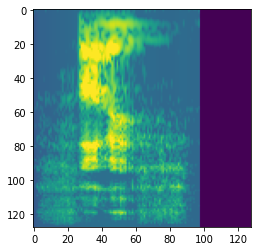

In [20]:
# Display image.
train_features = next(iter(data_A))
print(train_features.shape)
img = train_features[0].squeeze()
plt.imshow(img)
plt.show()

tensor([[-0.1764, -0.1396, -0.3983,  ..., -1.0000, -1.0000, -1.0000],
        [-0.2234, -0.2559, -0.3983,  ..., -1.0000, -1.0000, -1.0000],
        [-0.3012, -0.4311, -0.3983,  ..., -1.0000, -1.0000, -1.0000],
        ...,
        [-0.4363, -0.4311, -0.3983,  ..., -1.0000, -1.0000, -1.0000],
        [-0.4363, -0.4311, -0.3983,  ..., -1.0000, -1.0000, -1.0000],
        [-0.4363, -0.4311, -0.3983,  ..., -1.0000, -1.0000, -1.0000]])


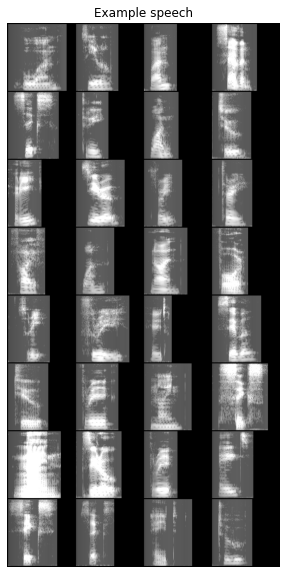

In [21]:
batch_tensor = next(iter(data_A))
print(batch_tensor[0][0])
grid_img = torchvision.utils.make_grid(batch_tensor, nrow=4, normalize=True)

plt.figure(figsize=(10, 10))
plt.title('Example speech')
plt.axis('off')
plt.imshow(grid_img.permute(1, 2, 0), origin="lower", cmap=plt.get_cmap("magma"))

In [22]:
# data_style_A, data_style_B, test_style_A, test_style_B = np.array_split(glob.glob(spect_dir+"*.npy"), 4)
# data_style_A.shape

In [23]:
# def read_spect_matrix(filenames):
#     images = []
#     for fn in filenames:
#         if fn[-3:] == 'mat':
#             image = scipy.io.loadmat(fn)
#             # pdb.set_trace()
#             image = image[fn[-12:-4]] #12 for val \, 14 for train
#             # make it 3x256x256
#             image = image.transpose(2,0,1)
#         elif fn[-3:] == 'npy':
#             image = np.load(fn)
#         if image is None:
#             continue
#         image = image.astype(np.float32)
#         # Saved as (3, 256, 256)
#         # image = image.transpose(2,0,1)
#         # pdb.set_trace( )
#         images.append( image )

#     images = np.stack( images )
#     return images

In [24]:
# test_A = read_spect_matrix( test_style_A )
# test_B = read_spect_matrix( test_style_B )

In [25]:
# test_A_V = Variable( torch.FloatTensor( test_A ), requires_grad=True)
# test_B_V = Variable( torch.FloatTensor( test_B ), requires_grad=True)

In [26]:
n_batches = min( len(data_A), len(data_B) )

print(n_batches)

156


In [27]:
# n_batches = ( data_size // batch_size )

# n_batches

In [28]:
recon_criterion = nn.L1Loss() #MSELoss()
gan_criterion = nn.BCELoss()
feat_criterion = nn.HingeEmbeddingLoss()
stl_criterion = nn.CrossEntropyLoss()

In [29]:
## Change to 3 inputs 
def get_gan_loss(dis_real, dis_fake1, dis_fake2, criterion, device):
    labels_dis_real = Variable(torch.ones( [dis_real.size()[0], 1] ))
    labels_dis_fake1 = Variable(torch.zeros([dis_fake1.size()[0], 1] ))
    labels_dis_fake2 = Variable(torch.zeros([dis_fake2.size()[0], 1] ))
    labels_gen1 = Variable(torch.ones([dis_fake1.size()[0], 1]))
    labels_gen2 = Variable(torch.ones([dis_fake2.size()[0], 1]))

    labels_dis_real = labels_dis_real.to(device)
    labels_dis_fake1 = labels_dis_fake1.to(device)
    labels_dis_fake2 = labels_dis_fake2.to(device)
    labels_gen1 = labels_gen1.to(device)
    labels_gen2 = labels_gen2.to(device)
    
    dis_real = torch.reshape(dis_real, (batch_size,1))
    dis_fake1 = torch.reshape(dis_fake1, (batch_size,1))
    dis_fake2 = torch.reshape(dis_fake2, (batch_size,1))
    
    dis_loss = criterion( dis_real, labels_dis_real ) * 0.4 + criterion( dis_fake1, labels_dis_fake1 ) * 0.3 + criterion( dis_fake2, labels_dis_fake2 ) * 0.3
    gen_loss = criterion( dis_fake1, labels_gen1 ) * 0.5 + criterion( dis_fake2, labels_gen2 ) * 0.5

    return dis_loss, gen_loss

In [30]:
def get_fm_loss(real_feats, fake_feats, criterion, device):
    losses = 0
    for real_feat, fake_feat in zip(real_feats, fake_feats):
        # pdb.set_trace()
        l2 = (real_feat.mean(0) - fake_feat.mean(0)) * (real_feat.mean(0) - fake_feat.mean(0))
        loss = criterion( l2, Variable( torch.ones( l2.size() ) ).to(device) )
        losses += loss

    return losses

In [31]:
## Use CrossEntropyLoss: target should be N
def get_stl_loss(A_stl, A1_stl, A2_stl, B_stl, B1_stl, B2_stl, criterion, device):
    # for nn.CrossEntropyLoss, the target is class index.
    labels_A = Variable(torch.ones( A_stl.size()[0] )) # NLL/CE target N not Nx1
    labels_A.data =  labels_A.data.type(torch.LongTensor)

    labels_A1 = Variable(torch.ones( A1_stl.size()[0] )) # NLL/CE target N not Nx1
    labels_A1.data =  labels_A1.data.type(torch.LongTensor)

    labels_A2 = Variable(torch.ones( A2_stl.size()[0] )) # NLL/CE target N not Nx1
    labels_A2.data =  labels_A2.data.type(torch.LongTensor)
 
    labels_B = Variable(torch.zeros(B_stl.size()[0] ))
    labels_B.data =  labels_B.data.type(torch.LongTensor)

    labels_B1 = Variable(torch.zeros(B1_stl.size()[0] ))
    labels_B1.data =  labels_B1.data.type(torch.LongTensor)

    labels_B2 = Variable(torch.zeros(B2_stl.size()[0] ))
    labels_B2.data =  labels_B2.data.type(torch.LongTensor)
   
    labels_A = labels_A.to(device)
    labels_A1 = labels_A1.to(device)
    labels_A2 = labels_A2.to(device)
    labels_B = labels_B.to(device)
    labels_B1 = labels_B1.to(device)
    labels_B2 = labels_B2.to(device)

    A_stl = np.squeeze(A_stl)
    A1_stl = np.squeeze(A1_stl)
    A2_stl = np.squeeze(A2_stl)
    B_stl = np.squeeze(B_stl)
    B1_stl = np.squeeze(B1_stl)
    B2_stl = np.squeeze(B2_stl)

    stl_loss_A = criterion( A_stl, labels_A ) * 0.2 + criterion( A1_stl, labels_A1 ) * 0.15 + criterion( A2_stl, labels_A2 ) * 0.15
    stl_loss_B = criterion( B_stl, labels_B ) * 0.2 + criterion( B1_stl, labels_B1 ) * 0.15 + criterion( B2_stl, labels_B2 ) * 0.15
    stl_loss = stl_loss_A + stl_loss_B

    return stl_loss

In [32]:
def delta_regu(input_v, batch_size, criterion=nn.MSELoss()):
    losses = 0
    for i in range(batch_size):
        # pdb.set_trace()
        input_temp = np.squeeze(input_v.data[i,:,:,:])
        # no need to take mean among 3 channels since current input is 256x256 instead of 3x256x256
        input_temp = input_temp.cpu().numpy()
        input_delta = np.absolute(librosa.feature.delta(input_temp))
        b = input_delta.shape[1]
        delta_loss = criterion(Variable((torch.from_numpy(input_delta)).type(torch.DoubleTensor)), Variable((torch.zeros([128,b])).type(torch.DoubleTensor)))
        # delta_loss = criterion((torch.from_numpy(input_delta)), Variable((torch.zeros([256,256]))))
        losses += delta_loss

    delta_losses = losses/batch_size

    return delta_losses.type(torch.cuda.FloatTensor)  
    # return delta_losses.type(torch.FloatTensor)

In [71]:
generator_A = Generator(ngpu)
generator_B = Generator(ngpu)
discriminator_A = Discriminator(ngpu)
discriminator_B = Discriminator(ngpu)
discriminator_S = StyleDiscriminator(ngpu)

generator_A = generator_A.to(device)
generator_B = generator_B.to(device)
discriminator_A = discriminator_A.to(device)
discriminator_B = discriminator_B.to(device)
discriminator_S = discriminator_S.to(device)
    
if ngpu > 1:
    generator_A = nn.DataParallel(generator_A, device_ids = range(ngpu))
    generator_B = nn.DataParallel(generator_B, device_ids = range(ngpu))
    discriminator_A = nn.DataParallel(discriminator_A, device_ids = range(ngpu))
    discriminator_B = nn.DataParallel(discriminator_B, device_ids = range(ngpu))
    discriminator_S = nn.DataParallel(discriminator_S, device_ids = range(ngpu)) 

In [72]:
# print(generator_A)

In [73]:
gen_params = chain(generator_A.parameters(), generator_B.parameters())
dis_params = chain(discriminator_A.parameters(), discriminator_B.parameters())
stl_params =  discriminator_S.parameters() 

In [74]:
gen_params

In [75]:
# for i, (A,B) in enumerate(zip(data_A,data_B)):
#     A = Variable(A).to(device)
    
#     print(A.shape)
    
#     AB, AL_feats, LAB_feats = generator_B(A)

In [76]:
learning_rate = 0.01
nz = 1

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(32, nz, 128, 128, device=device)

optim_gen = optim.Adam( gen_params, lr=learning_rate, betas=(0.5,0.999), weight_decay=0.00001)
optim_dis = optim.Adam( dis_params, lr=learning_rate, betas=(0.5,0.999), weight_decay=0.00001)
optim_stl = optim.Adam( stl_params, lr=learning_rate, betas=(0.5,0.999), weight_decay=0.00001)

# sched_gen = optim.lr_scheduler.ExponentialLR(optim_gen, gamma=0.9)
# sched_dis = optim.lr_scheduler.ExponentialLR(optim_dis, gamma=0.9)
# sched_stl = optim.lr_scheduler.ExponentialLR(optim_stl, gamma=0.9)

iters = 0
start = time.time()    

In [77]:
print(next(iter(data_A)).size())
print(next(iter(data_B)).size())

torch.Size([32, 1, 128, 128])
torch.Size([32, 1, 128, 128])


In [78]:
def plot_grad_flow(named_parameters, filename):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.cpu().abs().mean())
            max_grads.append(p.grad.cpu().abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation=30)
    plt.xlim(left=0, right=len(ave_grads))
    # plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])
    plt.savefig( os.path.join("results/gradients/", str( filename ) + ".jpg"))

In [86]:
epoch_size = 1

# Strong GAN loss for certain period at the beginning
gan_curriculum = 1000
# Set the lambda weight between GAN loss and Recon loss during curriculum period at the beginning. We used the 0.01 weight
starting_rate = 0.01
# Set the lambda weight between GAN loss and Recon loss after curriculum period. We used the 0.5 weight
default_rate = 0.5
# choose among gan/recongan/discogan/spec_gan. gan - standard GAN, recongan - GAN with reconstruction, discogan - DiscoGAN, spec_gan - My modified GAN model for speech
model_arch = "spec_gan"
# Print loss values every log_interval iterations
log_interval = epoch_size
# Save test results every image_save_interval iterations
image_save_interval = 2000
# Save models every model_save_interval iterations
model_save_interval = 10000
# Set the path for trained models
model_path = "./models/"
task_name = "spectrogram"

model_path = os.path.join( model_path, task_name )
model_path = os.path.join( model_path, model_arch )

Path(model_path).mkdir(parents=True, exist_ok=True)

result_path = './results'
update_interval = 10

log_gen_loss = np.array([])
log_dis_loss = np.array([])
log_stl_loss = np.array([])
log_delta_A = np.array([])
log_delta_B = np.array([])
log_fm_loss_A = np.array([])
log_fm_loss_B = np.array([])
log_recon_loss_A = np.array([])
log_recon_loss_B = np.array([])
log_gen_loss_A = np.array([])
log_gen_loss_B = np.array([])
img_list = []

plt.figure(figsize=(10, 15))

for epoch in range(epoch_size):    
    epoch_stats = defaultdict(lambda: 0)
    widgets = ['epoch #%d|' % epoch, Percentage(), Bar(), ETA()]
    pbar = ProgressBar(maxval=n_batches, widgets=widgets)
    pbar.start()
        
    for i, (A,B) in enumerate(zip(data_A,data_B)):
        pbar.update(i)

        generator_A.zero_grad()
        generator_B.zero_grad()
        discriminator_A.zero_grad()
        discriminator_B.zero_grad()
        discriminator_S.zero_grad()
           
        A = Variable( torch.FloatTensor( A ) ).to(device)
        B = Variable( torch.FloatTensor( B ) ).to(device)

        # test_A_V = Variable( torch.FloatTensor( t_A ), requires_grad=True )
        # test_B_V = Variable( torch.FloatTensor( t_B ), requires_grad=True )
    
        # A -> AB -> ABA
        # A = A.unsqueeze(1)
        AB, AL_feats, LAB_feats = generator_B(A)
        ABA, ABL_feats, ABLA_feats = generator_A(AB)
        # B -> BA -> BAB
        # B = B.unsqueeze(1)
        BA, BL_feats, LBA_feats = generator_A(B)
        BAB, BAL_feats, BALB_feats = generator_B(BA)
        
        recon_loss_BA = recon_criterion( BA, B)
        recon_loss_AB = recon_criterion( AB, A)
        recon_loss_ABA = recon_criterion( ABA, A)
        recon_loss_BAB = recon_criterion( BAB, B)
        
        recon_loss_A = 30 *recon_loss_AB + 70 * recon_loss_ABA
        recon_loss_B = 30 *recon_loss_BA + 70 * recon_loss_BAB 
        
        # Real/Fake GAN Loss (A)
        A_dis = discriminator_A( A )
        BA_dis = discriminator_A( BA )
        ABA_dis = discriminator_A( ABA )
        
        # will be strange in one epoch
        dis_loss_A, gen_loss_A = get_gan_loss( A_dis, BA_dis, ABA_dis, gan_criterion, device)
                
        fm_loss_A1 = get_fm_loss(AL_feats, ABLA_feats, feat_criterion, device)
        fm_loss_A2 = get_fm_loss(LAB_feats, ABL_feats, feat_criterion, device)
        fm_loss_A = fm_loss_A1 + fm_loss_A2
        
        # Real/Fake GAN Loss (B)
        B_dis = discriminator_B( B )
        AB_dis = discriminator_B( AB )
        BAB_dis = discriminator_B( BAB )

        dis_loss_B, gen_loss_B = get_gan_loss( B_dis, AB_dis, BAB_dis, gan_criterion, device)
        fm_loss_B1 = get_fm_loss( BL_feats, BALB_feats, feat_criterion, device)
        fm_loss_B2 = get_fm_loss( LBA_feats, BAL_feats, feat_criterion, device)
        fm_loss_B = fm_loss_B1 + fm_loss_B2
        
        # Style Discriminator Loss
        A_stl = discriminator_S(A)
        B_stl = discriminator_S(B)
        AB_stl = discriminator_S(AB) 
        BA_stl = discriminator_S(BA)
        ABA_stl = discriminator_S(ABA) 		
        BAB_stl = discriminator_S(BAB)
        
        stl_loss = get_stl_loss(A_stl, BA_stl, ABA_stl, B_stl, AB_stl, BAB_stl, stl_criterion, device)

        # Delta regularizer
        BA_delta = delta_regu(BA, batch_size)
        AB_delta = delta_regu(AB, batch_size)
        ABA_delta = delta_regu(ABA, batch_size)
        BAB_delta = delta_regu(BAB, batch_size)

        delta_A = BA_delta + ABA_delta
        delta_B = AB_delta + BAB_delta
        
        # Total Loss
        if iters < gan_curriculum:
            rate = starting_rate
        else:
            rate = default_rate
            
        gen_loss_A_total = (gen_loss_A) * (1.-rate) + (recon_loss_A*0.6 + fm_loss_A*0.3 + delta_A*0.1)*rate
        gen_loss_B_total = (gen_loss_B) * (1.-rate) + (recon_loss_B*0.6 + fm_loss_B*0.3 + delta_B*0.1)*rate
        
        if model_arch == 'discogan':
            gen_loss = gen_loss_A_total + gen_loss_B_total
            dis_loss = dis_loss_A + dis_loss_B
        elif model_arch == 'spec_gan':
            gen_loss = gen_loss_A_total + gen_loss_B_total
            dis_loss = dis_loss_A + dis_loss_B + stl_loss
        elif model_arch == 'recongan':
            gen_loss = gen_loss_A_total
            dis_loss = dis_loss_B
        elif model_arch == 'gan':
            gen_loss = (gen_loss_B*0.1 + fm_loss_B*0.9)
            dis_loss = dis_loss_B
            
        if iters % update_interval == 0:
            dis_loss.backward()
            optim_dis.step()
            optim_stl.step()
            
            # sched_dis.step()
            # sched_stl.step()
        else:
            gen_loss.backward()
            optim_gen.step()
            
            # sched_gen.step()
            
        if i % 50 == 0:
        # if iters % log_interval == 0:
            print("---------------------")
            print("GEN Loss:", as_np(gen_loss_A.mean()), as_np(gen_loss_B.mean()))
            print("Feature Matching Loss:", as_np(fm_loss_A.mean()), as_np(fm_loss_B.mean()))
            print("RECON Loss:", as_np(recon_loss_A.mean()), as_np(recon_loss_B.mean()))
            print("DIS Loss:", as_np(dis_loss_A.mean()), as_np(dis_loss_B.mean()))
            print("Style Loss:", as_np(stl_loss.mean()))
            print("Delta Loss:", as_np(delta_A.mean()), as_np(delta_B.mean()))
            print("Time", (time.time()-start))
            start = time.time()     
                        
            log_gen_loss = np.hstack([log_gen_loss, as_np(gen_loss.mean())])
            log_dis_loss = np.hstack([log_dis_loss, as_np(dis_loss.mean())])
            log_stl_loss = np.hstack([log_stl_loss, as_np(stl_loss.mean())])
            log_delta_A = np.hstack([log_delta_A, as_np(delta_A.mean())])
            log_delta_B = np.hstack([log_delta_B, as_np(delta_B.mean())])
            log_fm_loss_A = np.hstack([log_fm_loss_A, as_np(fm_loss_A.mean())])
            log_recon_loss_A = np.hstack([log_recon_loss_A, as_np(recon_loss_A.mean())])
            log_fm_loss_B = np.hstack([log_fm_loss_B, as_np(fm_loss_B.mean())])
            log_recon_loss_B = np.hstack([log_recon_loss_B, as_np(recon_loss_B.mean())])
            log_gen_loss_A = np.hstack([log_gen_loss_A, as_np(gen_loss_A.mean())])
            log_gen_loss_B = np.hstack([log_gen_loss_B, as_np(gen_loss_B.mean())])
            
            epoch_stats['log_gen_loss'] = log_gen_loss
                
        if iters % model_save_interval == 0:
            torch.save( generator_A, os.path.join(model_path, 'model_gen_A-' + str( iters / model_save_interval )))
            torch.save( generator_B, os.path.join(model_path, 'model_gen_B-' + str( iters / model_save_interval )))
            torch.save( discriminator_A, os.path.join(model_path, 'model_dis_A-' + str( iters / model_save_interval )))
            torch.save( discriminator_B, os.path.join(model_path, 'model_dis_B-' + str( iters / model_save_interval )))
                    
        if epoch % 5 == 0 and iters % 10 == 0:
            print('Epoch: '+str(epoch))
            for k, v in epoch_stats.items():
                print(' %s=%6.4f' % (k, v[-1] / iters), end='')

            images_for_plot = {
                'real_a': A, 'fake_ab': AB, 'cycle_aba': ABA,
                'real_b': B, 'fake_ba': BA, 'cycle_bab': BAB,
            }

            for k in range(3):
                for i, (im_title, im) in enumerate(images_for_plot.items()):
                    plt.subplot(3, 6, k * 6 + i + 1)
                    plt.imshow(im[k].detach().cpu().numpy().transpose(1, 2, 0) / 2 + 0.5)
                    if k == 0:
                        plt.title(im_title)
                    plt.axis('off')
                    
            plt.tight_layout()
            display(plt.gcf())
            clear_output(wait=True)
            plt.savefig( os.path.join("results/images/", 'model-' + str( epoch ) + ".jpg"))
            
            plt.figure(figsize=(10,5))
            plt.title("Generator, Discriminator and StyleDiscriminator Loss During Training")
            plt.plot(log_gen_loss,label="G")
            plt.plot(log_dis_loss,label="D")
            plt.plot(log_stl_loss,label="S")
            plt.xlabel("iterations")
            plt.ylabel("Loss")
            plt.legend()
            plt.savefig( os.path.join("results/", 'model-' + str( epoch ) + ".jpg"))
            plt.show()
            
            plot_grad_flow(discriminator_A.named_parameters(), 'discriminator_A')
            plot_grad_flow(discriminator_B.named_parameters(), 'discriminator_B')
            plot_grad_flow(discriminator_S.named_parameters(), 'discriminator_S')
            plot_grad_flow(generator_A.named_parameters(), 'generator_A')
            plot_grad_flow(generator_B.named_parameters(), 'generator_B')
    
        iters += 1
        
sio.savemat(result_path +'/log_gen_loss.mat', {'log_gen_loss':log_gen_loss})
sio.savemat(result_path +'/log_dis_loss.mat', {'log_dis_loss':log_dis_loss})
sio.savemat(result_path +'/log_stl_loss.mat', {'log_stl_loss':log_stl_loss})
sio.savemat(result_path +'/log_delta_A.mat', {'log_delta_A':log_delta_A})
sio.savemat(result_path +'/log_delta_B.mat', {'log_delta_B':log_delta_B})
sio.savemat(result_path +'/log_gen_loss_A.mat', {'log_gen_loss_A':log_gen_loss_A})
sio.savemat(result_path +'/log_gen_loss_B.mat', {'log_gen_loss_B':log_gen_loss_B})
sio.savemat(result_path +'/log_fm_loss_A.mat', {'log_fm_loss_A':log_fm_loss_A}) 
sio.savemat(result_path +'/log_fm_loss_B.mat', {'log_fm_loss_B':log_fm_loss_B})
sio.savemat(result_path +'/log_recon_loss_A.mat', {'log_recon_loss_A':log_recon_loss_A}) 
sio.savemat(result_path +'/log_recon_loss_B.mat', {'log_recon_loss_B':log_recon_loss_B})

---------------------
GEN Loss: 3.1433787 2.2330413
Feature Matching Loss: 2.496266 2.407796
RECON Loss: 82.34275 78.55147
DIS Loss: 0.30646116 0.5061513
Style Loss: 0.8834566
Delta Loss: 0.011327116 0.01230558
Time 11.69909143447876


TypeError: tensor or list of tensors expected, got <class 'tuple'>

<Figure size 720x1080 with 0 Axes>

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(data_A))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()